## Introduction

In this notebook, we will explore a dataset containing the 1500 most profitable games on Steam. The data was obtained from the service [Gamalytic](https://gamalytic.com/), with the snapshot taken on 09-09-2024.

### Important Considerations

According to the description provided by Gamalytic, the data represents estimates rather than exact figures. It's important to keep in mind the following limitations when analyzing the dataset:

1. **Sales Data**: The exact number of copies sold cannot be precisely reconstructed from the available data.
2. **Discounts**: Information about discounts applied to games is not included, and this could significantly impact the total revenue estimates.
3. **Regional Pricing**: Steam offers regional pricing that can vary considerably between different countries, and these variations are not fully captured in the dataset.

Therefore, when drawing conclusions or conducting simple data consistency checks, these limitations should be considered.

In [1]:
import pandas as pd
import numpy as np
import requests
import time
import json_tricks as jt
import itertools
from collections import Counter
import calendar
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('Steam_2024_bestRevenue_1500.csv')

In [5]:
df.head()

,name,releaseDate,copiesSold,price,revenue,avgPlaytime,reviewScore,publisherClass,publishers,developers,steamId
0,WWE 2K24,07-03-2024,165301,99.99,8055097.0,42.365140,71,AAA,2K,Visual Concepts,2315690
1,EARTH DEFENSE FORCE 6,25-07-2024,159806,59.99,7882151.0,29.651061,57,Indie,D3PUBLISHER,SANDLOT,2291060
2,Sins of a Solar Empire II,15-08-2024,214192,49.99,7815247.0,12.452593,88,Indie,Stardock Entertainment,"Ironclad Games Corporation,Stardock Entertainment",1575940
3,Legend of Mortal,14-06-2024,440998,19.99,7756399.0,24.797817,76,Indie,"Paras Games,Obb Studio Inc.",Obb Studio Inc.,1859910
4,Shin Megami Tensei V: Vengeance,13-06-2024,141306,59.99,7629252.0,34.258496,96,AA,SEGA,ATLUS,1875830


In [7]:
df.dtypes

name               object
releaseDate        object
copiesSold          int64
price             float64
revenue           float64
avgPlaytime       float64
reviewScore         int64
publisherClass     object
publishers         object
developers         object
steamId             int64
dtype: object

In [9]:
df['releaseDate'] = pd.to_datetime(df['releaseDate'], format = '%d-%m-%Y')

In [11]:
df.describe()

,releaseDate,copiesSold,price,revenue,avgPlaytime,reviewScore,steamId
count,1500,1.500000e+03,1500.000000,1.500000e+03,1500.000000,1500.000000,1.500000e+03
mean,2024-05-04 21:23:31.199999744,1.414826e+05,17.519513,2.632382e+06,12.562704,76.201333,2.183788e+06
min,2024-01-01 00:00:00,5.930000e+02,0.000000,2.067400e+04,0.000000,0.000000,2.488000e+04
25%,2024-03-07 00:00:00,4.918750e+03,9.990000,4.550425e+04,3.564848,72.000000,1.792795e+06
50%,2024-05-02 00:00:00,1.192850e+04,14.990000,1.090530e+05,6.762776,83.000000,2.321985e+06
75%,2024-06-27 00:00:00,3.786975e+04,19.990000,4.551568e+05,13.104473,92.000000,2.693228e+06
max,2024-09-06 00:00:00,3.073915e+07,99.990000,8.377934e+08,296.332852,100.000000,3.107330e+06
std,NaN,1.132757e+06,12.646612,2.781024e+07,21.542173,24.319438,6.067725e+05


In [136]:
# Price ranges between $0 and $99.9. On average, it's $15, and 75% of the games are priced at $20 or lower – not many big-budget games.
# Playtime ranges from 0 to 296 hours. On average, it's 7 hours, and 75% of the games don't exceed 13 hours.
# Not many open-world, sandbox, or multiplayer projects?
# Most games have high ratings (25% of them are 72 or higher).
# The dataset is from 2024-09-09, with the latest release date being 2024-09-06 – not much time for the latest games to accumulate revenue.

In [15]:
df.columns

Index(['name', 'releaseDate', 'copiesSold', 'price', 'revenue', 'avgPlaytime',
       'reviewScore', 'publisherClass', 'publishers', 'developers', 'steamId'],
      dtype='object')

## Profit Estimate Validation and Correction Attempts

In this section, we will validate the revenue estimates and attempt to make corrections.

A simple way to check the `revenue` field is to create a rough estimate of profit by multiplying the estimated number of copies sold by the price. In theory, the profit should not exceed this calculated value. However, in practice, as will be demonstrated below, prices can decrease over time and may not align with the prices in our dataset snapshot.

Next, we will attempt to address this issue using historical data obtained from the service [IsThereAnyDeal](https://docs.isthereanydeal.com/).

Additionally, the dataset will be supplemented with tags, the presence of achievements, and the time from release to discount, among other factors.

In [21]:
df['calculatedRevenue'] = df['price'] * df['copiesSold']
df['revenueDifference'] = (df['calculatedRevenue'] - df['revenue'])/df['calculatedRevenue']
df.loc[np.isinf(df['revenueDifference']), 'revenueDifference'] = np.NaN

array([[<Axes: title={'center': 'AA'}>, <Axes: title={'center': 'AAA'}>],
       [<Axes: title={'center': 'Hobbyist'}>,
        <Axes: title={'center': 'Indie'}>]], dtype=object)

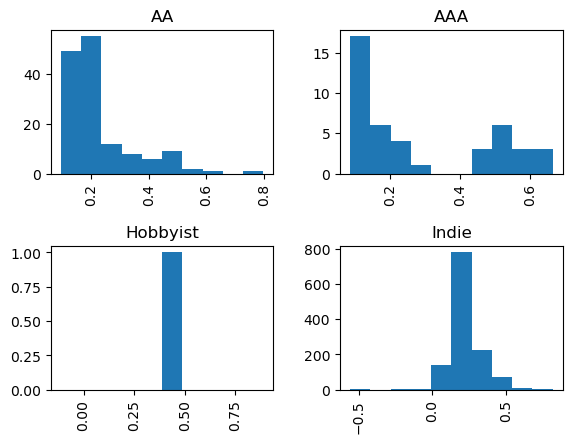

In [23]:
df.hist(column = 'revenueDifference', by= 'publisherClass')

In [25]:
# Negative values indicate that revenue exceeds the total cost * number of copies sold.
# Let's take a look at such games.
df_revenue_problems = df[(df['price'] > 0) & (df['calculatedRevenue'] < df['revenue'])]

In [27]:
df_revenue_problems.count()

name                 7
releaseDate          7
copiesSold           7
price                7
revenue              7
avgPlaytime          7
reviewScore          7
publisherClass       7
publishers           7
developers           7
steamId              7
calculatedRevenue    7
revenueDifference    7
dtype: int64

In [29]:
df_revenue_problems.head()

,name,releaseDate,copiesSold,price,revenue,avgPlaytime,reviewScore,publisherClass,publishers,developers,steamId,calculatedRevenue,revenueDifference
61,Contain,2024-01-16,12768,13.99,255512.0,2.503694,60,Indie,SinginGiant,SinginGiant,2186700,178624.32,-0.430444
104,Coreborn,2024-06-19,14796,13.99,216265.0,30.494220,67,Indie,Blankhans,Blankhans,1926090,206996.04,-0.044778
501,月藍傳奇REMAKE古文明之謎,2024-02-11,2607,19.99,65028.0,40.438272,96,Indie,RMAsia,"天使蛋糕,攸藍,牙籤,黃金,咕咕咕,鎧特",2391680,52113.93,-0.247805
909,IIslands of War,2024-03-10,3885,4.99,30192.0,11.074408,87,Indie,jwiggs,jwiggs,1162470,19386.15,-0.557401
957,On Dark Terms,2024-02-06,2200,7.99,27226.0,6.475463,69,Indie,Dimensionless Games,Dimensionless Games,2159530,17578.00,-0.548868


In [139]:
# A total of 7 games.
# A quick check shows that for example, for "Contain" the current price is $13.99 (price at the time of the snapshot). The original price was $29.99.
# With such a price, it's quite possible to reach the reported revenue amount.
# https://steamdb.info/app/2186700/

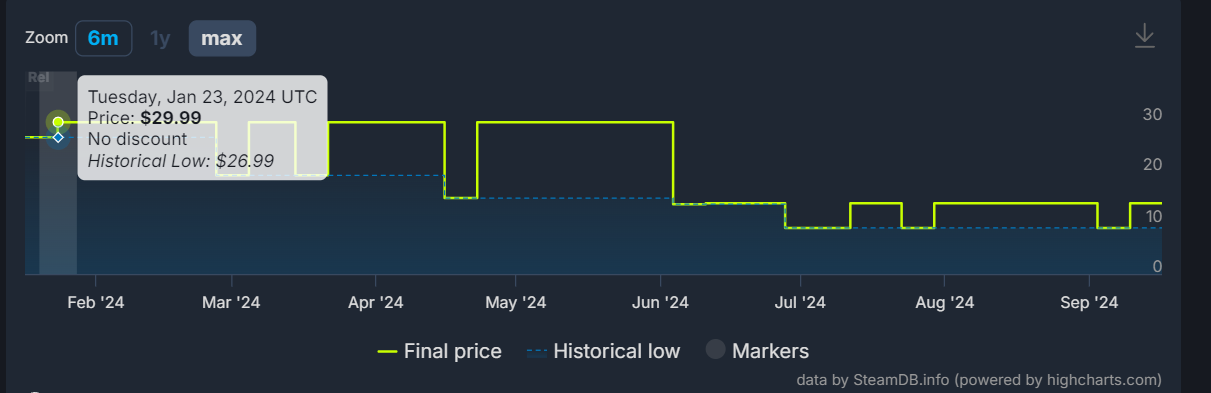

In [143]:
# Let's add information about the maximum price for further analysis.
# To this end, we will use the API from the service https://docs.isthereanydeal.com/.

In [35]:
API_KEY = 'INSERT_YOUR_KEY'
STEAM_ID = 61

BASE_URL = 'https://api.isthereanydeal.com/'
LOOKUP_ENDPOINT = 'games/lookup/v1'
INFO_ENDPOINT = 'games/info/v2'
HISTORY_ENDPOINT = 'games/history/v2'

In [37]:
def price_history(x):
  return {'datetime': x['timestamp'], 'price': x['deal']['price']['amount'], 'discount': x['deal']['cut'] > 0}

def get_additional_info(x):
    time.sleep(5)
    app_id = x['steamId']
    lookup_resp = requests.get(BASE_URL + LOOKUP_ENDPOINT, params = {'key': API_KEY, 'appid': app_id})
    game_id = lookup_resp.json()['game']['id']
    base_info = requests.get(BASE_URL + INFO_ENDPOINT, params = {'key': API_KEY, 'id': game_id})
    release_date = x['releaseDate'].tz_localize('UTC').isoformat()
    history = requests.get(url, params = {'key': API_KEY, 'id': game_id, 'country': 'US', 'shops': STEAM_ID, 'since': release_date})
    info_dict = {
        'steamId': x['steamId'], 
        'achievements': base_info.json()['achievements'],
        'tradingCards': base_info.json()['tradingCards'],
        'tags': base_info.json()['tags'],
        'history': list(map(price_history, history.json())),
    }
    return info_dict

In [39]:
# additional_info = df.apply(get_additional_info, axis=1)

In [41]:
additional_values_json = 'additional_values.json'

In [43]:
# with open(additional_values_json, 'w') as outfile:
#     jt.dump(additional_info, outfile)

In [45]:
additional_info = None
with open(additional_values_json, 'r') as infile:
    additional_info = jt.load(infile)

## Simple Feature Engineering
For each tag, we will create a separate column, where there will be a 1 if the game has that tag and a 0 if it does not. Of course, it doesn't make sense to consider all tags, as some occur too infrequently (some only once), and we do not have enough information for statistical analysis.
The price history will be transformed into fields: `max_price`, `started_with_discount`, `days_before_first_discount`, and `days_before_first_drop`.

In [49]:
# Let's collect all tags
tags = list(itertools.chain(*[item['tags'] for item in additional_info]))
tags_counter = Counter(tags)

In [51]:
# And remove some rare tags to reduce the dimension of the problem
len(tags_counter)

359

In [53]:
filtered_tags = {key: count for key, count in tags_counter.items() if count >= 20}

In [55]:
len(filtered_tags)

98

In [57]:
filtered_tags_list = list(filtered_tags.keys())
new_columns = {tag: 0 for tag in filtered_tags_list}
new_columns.update({
    'max_price': 0,
    'started_with_discount': False,
    'days_before_first_discount': 0,
    'days_before_first_drop': 0,
    'achievements': False,
    'tradingCards': False
})
new_df = pd.DataFrame(new_columns, index=df.index)
df = pd.concat([df, new_df], axis=1)

del new_df

In [59]:
df['max_price'] = df['max_price'].astype(float)

In [61]:
for info in additional_info:
    index = df[df['steamId'] == info['steamId']].index[0]
    df.loc[index, list(set(info['tags']) & set(filtered_tags_list))] = 1
    df.loc[index, 'achievements'] = info['achievements']
    df.loc[index, 'tradingCards'] = info['tradingCards']
    history_df = pd.DataFrame(info['history'])
    if history_df.shape[0] > 0:
        history_df['datetime'] = pd.to_datetime(history_df['datetime'], utc=True)
        start_date = history_df['datetime'].min()
        initial_price = history_df['price'].max()
        first_discount_date = history_df[history_df['discount'] == True]['datetime'].min()
        first_drop_date = history_df[(history_df['discount'] == False) & (history_df['price'] < initial_price)]['datetime'].min()
        days_to_first_discount = (first_discount_date - start_date).days if pd.notna(first_discount_date) else None
        days_to_first_drop = (first_drop_date - start_date).days if pd.notna(first_drop_date) else None
        df.loc[index, 'max_price'] = initial_price
        df.loc[index, 'started_with_discount'] = history_df.loc[history_df['datetime'] == start_date, 'discount'].iat[0]
        df.loc[index, 'days_before_first_discount'] = days_to_first_discount
        df.loc[index, 'days_before_first_drop'] = days_to_first_drop
    del history_df

In [63]:
df.loc[df['max_price'] == 0, 'max_price'] = df['price'][df['max_price'] == 0].values

## Max price approach thoughts

Let's try to compare the maximum profit estimate with the one obtained from Gamalytic again. Unfortunately, we were unable to rectify the situation for 4 games. 

Additionally, we can check the most optimistic scenario—assuming all copies were sold in the highest-priced region (Switzerland). However, this introduces further complications, as prices in this region are in Swiss francs, which means we would need to convert them to US dollars based on a dynamically changing exchange rate. 

In the absence of information regarding the timing of sales, this results in too many assumptions, so we will not pursue this approach.oach.
```

In [65]:
df['calculatedRevenue'] = df['max_price'] * df['copiesSold']
df['revenueDifference'] = (df['calculatedRevenue'] - df['revenue'])/df['calculatedRevenue']
df.loc[np.isinf(df['revenueDifference']), 'revenueDifference'] = np.NaN

array([[<Axes: title={'center': 'AA'}>, <Axes: title={'center': 'AAA'}>],
       [<Axes: title={'center': 'Hobbyist'}>,
        <Axes: title={'center': 'Indie'}>]], dtype=object)

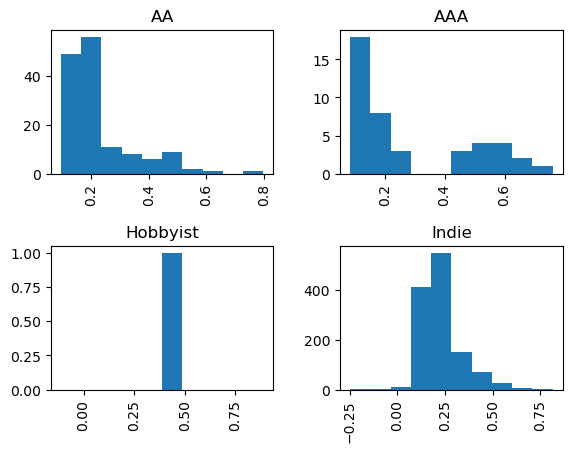

In [67]:
df.hist(column = 'revenueDifference', by= 'publisherClass')

In [69]:
df_revenue_problems = df[(df['price'] > 0) & (df['calculatedRevenue'] < df['revenue'])]

In [71]:
df_revenue_problems[['price', 'max_price', 'steamId']]

,price,max_price,steamId
104,13.99,13.99,1926090
501,19.99,19.99,2391680
1066,5.99,5.99,2642700
1298,14.99,14.99,1426050


In [73]:
list(map(lambda filtered: filtered['history'], filter(lambda info: info['steamId'] in df_revenue_problems['steamId'].values, additional_info)))

[[OrderedDict([('datetime', '2024-09-09T19:22:04+02:00'),
               ('price', 13.99),
               ('discount', False)]),
  OrderedDict([('datetime', '2024-09-02T19:24:17+02:00'),
               ('price', 4.19),
               ('discount', True)]),
  OrderedDict([('datetime', '2024-07-11T20:14:50+02:00'),
               ('price', 13.99),
               ('discount', False)]),
  OrderedDict([('datetime', '2024-06-19T15:15:30+02:00'),
               ('price', 9.79),
               ('discount', True)]),
  OrderedDict([('datetime', '2024-06-19T02:00:00+02:00'),
               ('price', 13.99),
               ('discount', False)])],
 [],
 [],
 [OrderedDict([('datetime', '2024-08-08T00:18:08+02:00'),
               ('price', 14.99),
               ('discount', False)]),
  OrderedDict([('datetime', '2024-07-25T01:00:15+02:00'),
               ('price', 11.99),
               ('discount', True)]),
  OrderedDict([('datetime', '2024-07-24T02:00:00+02:00'),
               ('price', 14.99),


In [149]:
# What about the "Hobbyist" class? It seems to be consistently sold at a discount or in low-priced markets.

In [77]:
df[df['publisherClass'] == 'Hobbyist']

,name,releaseDate,copiesSold,price,revenue,avgPlaytime,reviewScore,publisherClass,publishers,developers,...,Deckbuilding,Choose Your Own Adventure,Side Scroller,Comedy,max_price,started_with_discount,days_before_first_discount,days_before_first_drop,achievements,tradingCards
710,Pixel Noir,2024-02-08,3129,24.99,47871.0,8.461324,67,Hobbyist,NaN,SWDTech Games,...,0,0,0,0,24.99,False,0.0,NaN,True,False


In [151]:
# Ah, just one entry, so there’s no problem.

In [81]:
pd.set_option('display.max_columns', None)

In [83]:
df.describe()

,releaseDate,copiesSold,price,revenue,avgPlaytime,reviewScore,steamId,calculatedRevenue,revenueDifference,Sports,Simulation,Character Customization,Action,Shooter,3D,Online Co-Op,Strategy,RPG,Choices Matter,Multiple Endings,JRPG,Story Rich,Survival,Multiplayer,Open World Survival Craft,Sandbox,Building,City Builder,Colony Sim,Open World,Crafting,Singleplayer,PvE,Base Building,Resource Management,Adventure,Action-Adventure,Exploration,Metroidvania,Puzzle,Pixel Graphics,RTS,Fantasy,Sci-fi,FPS,3D Platformer,Funny,Action RPG,Sexual Content,Hentai,Mature,Nudity,NSFW,Difficult,Tower Defense,Atmospheric,Management,Automation,Psychological Horror,Female Protagonist,PvP,Auto Battler,First-Person,Free to Play,Life Sim,Cozy,Farming Sim,Cute,Indie,Roguelike Deckbuilder,Anime,Action Roguelike,Bullet Hell,Roguelite,2D,Racing,Realistic,Immersive Sim,Visual Novel,Interactive Fiction,Relaxing,Economy,Co-op,Horror,Dating Sim,Survival Horror,Dungeon Crawler,Hack and Slash,Point & Click,2D Platformer,Strategy RPG,Real Time Tactics,Roguelike,Turn-Based Tactics,Card Battler,Card Game,Casual,LGBTQ+,Romance,Turn-Based Strategy,Arcade,Idler,Platformer,Deckbuilding,Choose Your Own Adventure,Side Scroller,Comedy,max_price,days_before_first_discount,days_before_first_drop
count,1500,1.500000e+03,1500.000000,1.500000e+03,1500.000000,1500.000000,1.500000e+03,1.500000e+03,1415.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.0000,1500.000000,1500.000000,1500.00000,1500.000000,1500.000000,1500.0000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.0000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000,1500.000000,1500.000000,1345.000000,254.000000
mean,2024-05-04 21:23:31.199999744,1.414826e+05,17.519513,2.632382e+06,12.562704,76.201333,2.183788e+06,3.280593e+06,0.228167,0.021333,0.164000,0.014667,0.145333,0.037333,0.058000,0.044667,0.136000,0.146000,0.016000,0.013333,0.035333,0.042667,0.042000,0.067333,0.019333,0.048000,0.025333,0.03400,0.019333,0.046000,0.024667,0.076000,0.015333,0.031333,0.014667,0.154000,0.047333,0.073333,0.019333,0.048000,0.037333,0.020000,0.024667,0.016000,0.035333,0.01400,0.014667,0.032000,0.148000,0.064667,0.078000,0.108000,0.083333,0.01400,0.024667,0.025333,0.038667,0.014667,0.035333,0.032667,0.026000,0.013333,0.036000,0.014667,0.030667,0.01400,0.014667,0.037333,0.062000,0.018000,0.048667,0.052667,0.0240,0.047333,0.047333,0.01400,0.017333,0.042000,0.1000,0.024667,0.022667,0.015333,0.018667,0.064667,0.048667,0.015333,0.025333,0.026000,0.017333,0.031333,0.016000,0.014667,0.050000,0.026667,0.022000,0.0240,0.106667,0.016000,0.018000,0.025333,0.030000,0.022000,0.021333,0.022667,0.019333,0.01400,0.014667,17.603540,6.367286,4.933071
min,2024-01-01 00:00:00,5.930000e+02,0.000000,2.067400e+04,0.000000,0.000000,2.488000e+04,0.000000e+00,-0.247805,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [85]:
df[['price', 'max_price']].describe()

,price,max_price
count,1500.000000,1500.000000
mean,17.519513,17.603540
std,12.646612,12.566465
min,0.000000,0.000000
25%,9.990000,9.990000
50%,14.990000,14.990000
75%,19.990000,21.240000
max,99.990000,69.990000


In [87]:
df[df['price'] == 99.99]['steamId']

0    2315690
Name: steamId, dtype: int64

In [89]:
list(map(lambda filtered: filtered['history'], filter(lambda info: info['steamId'] == 2315690, additional_info)))

[[OrderedDict([('datetime', '2024-09-16T19:20:38+02:00'),
               ('price', 29.99),
               ('discount', True)]),
  OrderedDict([('datetime', '2024-08-15T19:18:46+02:00'),
               ('price', 59.99),
               ('discount', False)]),
  OrderedDict([('datetime', '2024-08-01T19:18:35+02:00'),
               ('price', 29.99),
               ('discount', True)]),
  OrderedDict([('datetime', '2024-07-11T20:38:53+02:00'),
               ('price', 59.99),
               ('discount', False)]),
  OrderedDict([('datetime', '2024-06-27T20:44:27+02:00'),
               ('price', 39.59),
               ('discount', True)]),
  OrderedDict([('datetime', '2024-06-17T19:16:26+02:00'),
               ('price', 59.99),
               ('discount', False)]),
  OrderedDict([('datetime', '2024-06-03T19:16:44+02:00'),
               ('price', 44.99),
               ('discount', True)]),
  OrderedDict([('datetime', '2024-04-18T19:15:54+02:00'),
               ('price', 59.99),
          

In [153]:
# Well... it seems either the price history is lacking, or we need to look beyond the US.
# We could examine the most expensive region (CH).
# However, prices will be in Swiss francs, which will need to be converted to USD.
# This, in turn, involves tying the prices to the exchange rates at the time of sale.
# But we do not know the timing of the sales.

In [93]:
df = df.drop(['calculatedRevenue', 'revenueDifference'], axis=1)

## Normalizing Profit Estimates

In this chapter, we will analyze the dataset using the snapshot from 09-09-2024. The last game in our list was released on 2024-09-06, giving it only 3 days to reach the top of the charts. 

To facilitate comparisons of profits among games released at different times, we aim to obtain a normalized profit value. The simplest method for achieving this is to divide the total profit by the number of days since the game's release.

However, it is important to note that this approach may not be entirely accurate. Profit is likely not distributed evenly over time; rather, it is typically concentrated around the release date and during sales events. Given the lack of information regarding the timing of sales, devising a more precise estimation becomes challenging. 

We will proceed with this normalization method as a preliminary analysis to gain insights into the profit distribution across different games.

In [156]:
df['releaseMonth'] = df['releaseDate'].dt.month_name()
month_order = list(calendar.month_name[1:])
df['releaseMonth'] = pd.Categorical(df['releaseMonth'], categories=month_order, ordered=True)

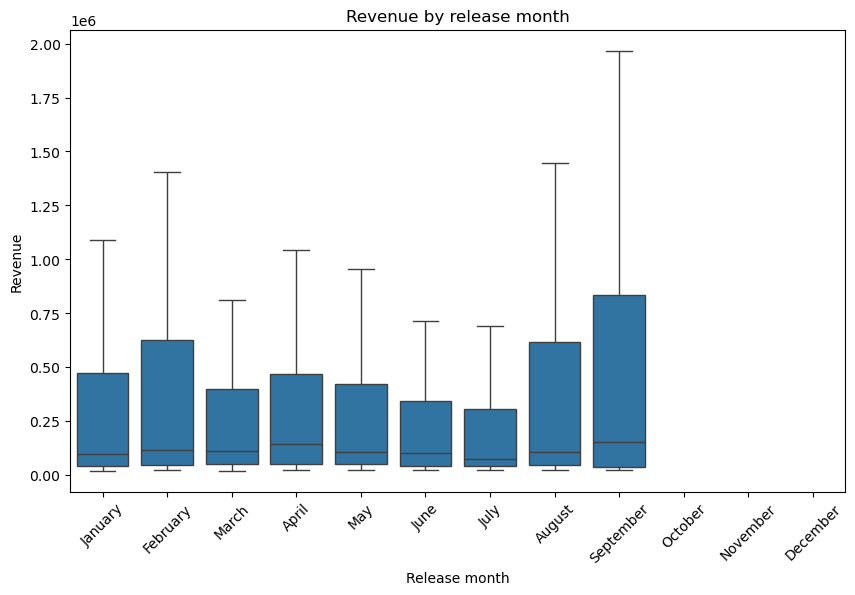

In [99]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='releaseMonth', y='revenue', data=df, showfliers=False)

plt.title('Revenue by release month')
plt.xlabel('Release month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.show()

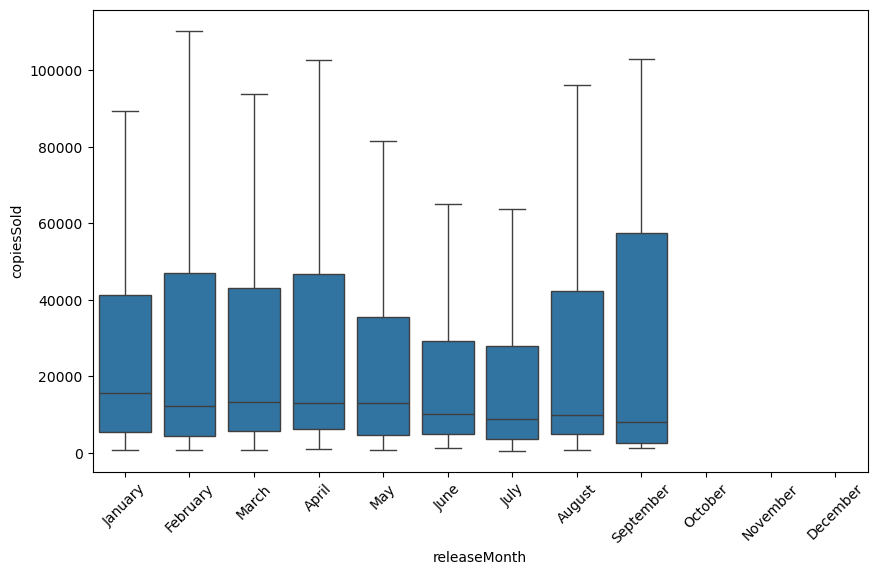

In [101]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='releaseMonth', y='copiesSold', data=df, showfliers=False)
plt.xticks(rotation=45)
plt.show()

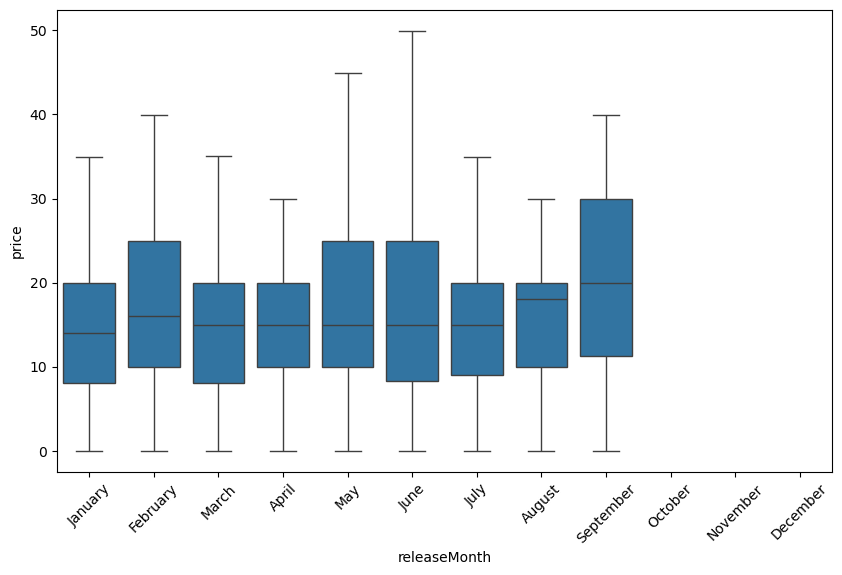

In [103]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='releaseMonth', y='price', data=df, showfliers=False)
plt.xticks(rotation=45)
plt.show()

In [105]:
cutoff_date = pd.to_datetime('2024-09-09')
df['revenue_per_week'] = df['revenue'] / (cutoff_date - df['releaseDate']).dt.days * 7

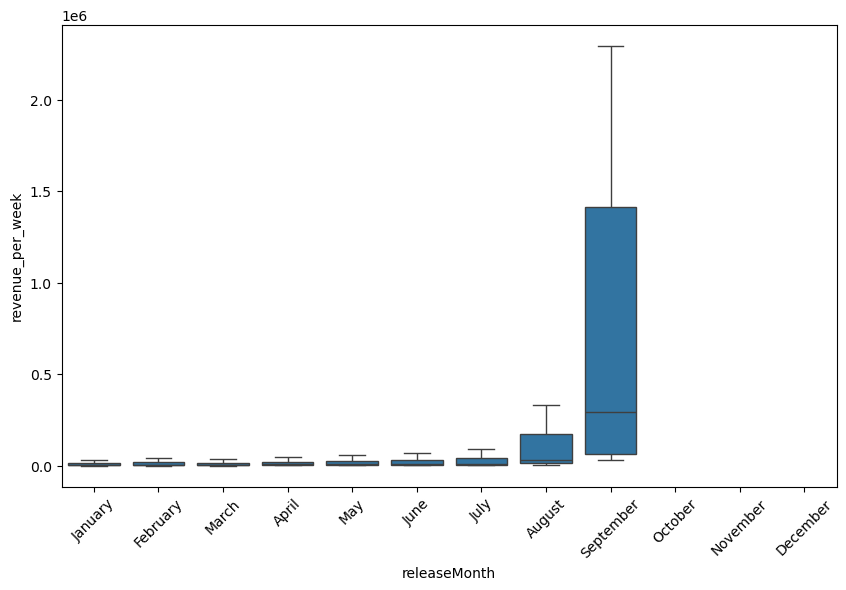

In [107]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='releaseMonth', y='revenue_per_week', data=df, showfliers=False)
plt.xticks(rotation=45)
plt.show()

In [164]:
month_counts = df['releaseMonth'].value_counts().sort_index()

In [166]:
month_counts

releaseMonth
January      144
February     182
March        201
April        204
May          229
June         174
July         173
August       163
September     30
October        0
November       0
December       0
Name: count, dtype: int64

At first glance, it might seem that more time since release is unnecessary for significant profit accumulation, as a substantial portion of profits typically comes within the initial days of sales. However, it's important to note that we have selected the most successful games released in September—so successful, in fact, that they managed to generate profits within their first few days that are comparable to what other games might earn over an entire year. 

Such exceptional games are rare and can significantly distort our statistical analysis.

In [111]:
df = df.drop(['revenue_per_week', 'releaseMonth'], axis=1)

## Continuation of Feature Engineering

In this section, we will continue our feature engineering efforts. The columns `publishers` and `developers` contain corresponding entities listed as comma-separated values. Similar to how we handled the tags, we will filter these entities and create additional columns for further analysis.


In [115]:
# Собираем всех издателей и разработчиков
publishers = df['publishers'].str.split(',').explode().str.strip()
publishers_counter = Counter(publishers)

In [117]:
filtered_publishers = {key: count for key, count in publishers_counter.items() if count >= 5}

In [119]:
len(filtered_publishers)

40

In [121]:
developers = df['developers'].str.split(',').explode().str.strip()
developers_counter = Counter(developers)
filtered_developers = {key: count for key, count in developers_counter.items() if count >= 5}

In [123]:
len(filtered_developers)

9

In [125]:
df.shape

(1500, 115)

In [127]:
for publisher in filtered_publishers.keys():
    df['pub_' + publisher] = df['publishers'].fillna('').str.contains(publisher).astype(int)
for developer in filtered_developers.keys():
    df['dev_' + developer] = df['developers'].fillna('').str.contains(developer).astype(int)

In [129]:
df.shape

(1500, 164)

In [131]:
augmented_csv = 'augmented_dataset.csv'

In [133]:
df.to_csv(augmented_csv, index=False) 

## Dataset Prepared for Further Analysis

At this stage, the dataset is now ready for further exploration and analysis.